# English data 

/Users/alaaeddinalia/Desktop/thesis_submission /Rumor_verification/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Accuracy: 0.5769
F1 Score (Micro): 0.5769
F1 Score (Macro): 0.5476
Confusion Matrix:
[[2 0 3]
 [1 4 5]
 [0 2 9]]


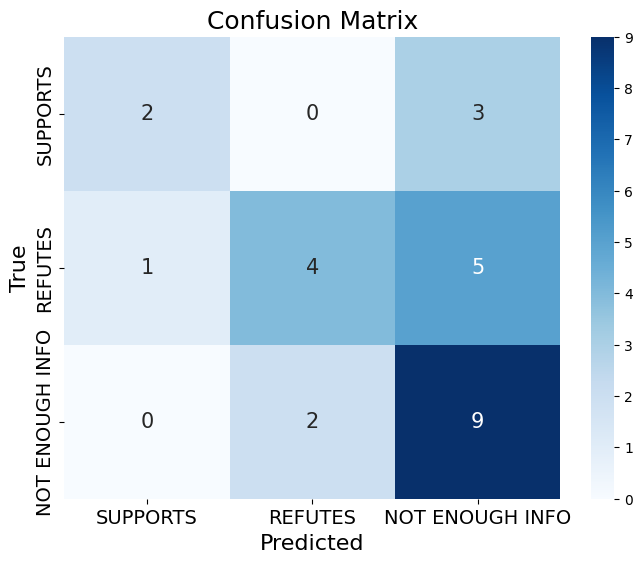

Accuracy: 0.6923
F1 Score (Micro): 0.6923
F1 Score (Macro): 0.6885
Confusion Matrix:
[[4 0 1]
 [2 5 3]
 [0 2 9]]


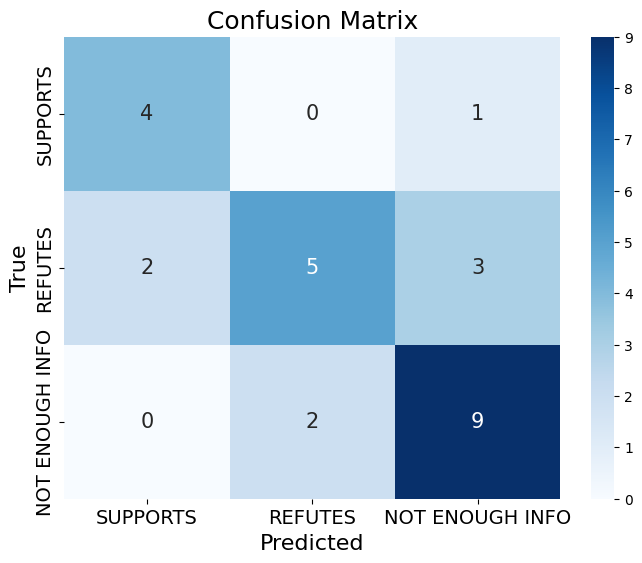

Accuracy: 0.5769
F1 Score (Micro): 0.5769
F1 Score (Macro): 0.5476
Confusion Matrix:
[[2 0 3]
 [1 4 5]
 [0 2 9]]


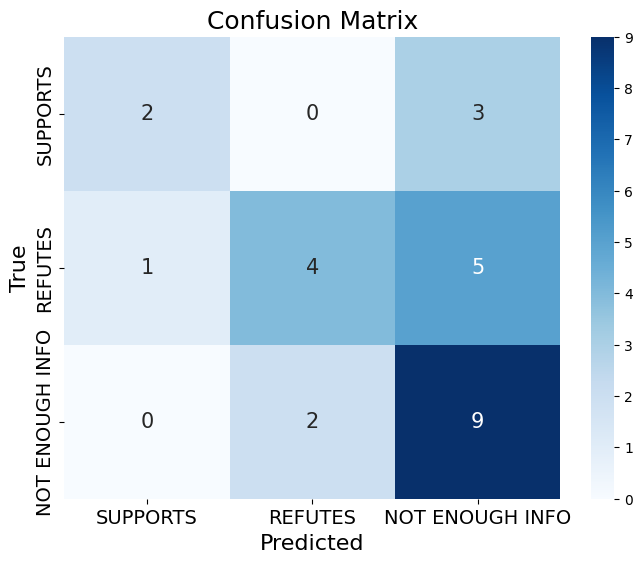

In [28]:
import torch
import numpy as np
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from preparing.data_loading import DataLoader
from preparing.data_cleaning import DataCleaner
from preparing.preprocessor import Preprocessor
from utils.preprocessing import preprocess_data
from utils.feature_extractor import FeatureExtractor
from utils.similarity_calculation import calculate_similarities
from evaluation.retrieval_evaluation import get_top_k_similar_timeline_entries
from evaluation.verification_evaluation import evaluate_llm_model
from utils.data_split import load_and_combine_datasets, stratified_split
from collections import Counter

# Load tokenizer and fine-tuned model
fine_tuned_model_path = '/Users/alaaeddinalia/Desktop/thesis_submission /Rumor_verification/src/traind_models/fine-tuned-xlm-roberta_EA'
tokenizer = XLMRobertaTokenizer.from_pretrained(fine_tuned_model_path)
model = XLMRobertaForSequenceClassification.from_pretrained(fine_tuned_model_path, num_labels=3)


train_file = '/Users/alaaeddinalia/Desktop/thesis_submission /Rumor_verification/data/raw/English_train.json'
dev_file = '/Users/alaaeddinalia/Desktop/thesis_submission /Rumor_verification/data/raw/English_dev.json'


#load data
data = load_and_combine_datasets(train_file, dev_file)

#clean data
cleaner = DataCleaner()
clean_data = cleaner.remove_invalid_tweets(data)

# Preprocess data
preprocessor = Preprocessor()
preprocessed_data = preprocess_data(data, preprocessor)

# Split the data into training and testing sets
train_data, test_data = stratified_split(preprocessed_data, label_key='label')

# Feature extractor (SBERT)
extractor = FeatureExtractor(method="sbert")

rumor_texts_test = [item['rumor'] for item in test_data]
timeline_texts_test = [timeline_entry[2] for item in test_data for timeline_entry in item['timeline']]

# Transform test data using SBERT
rumor_vectors_test = extractor.transform(rumor_texts_test)
timeline_vectors_test = extractor.transform(timeline_texts_test)

# Assign vectors back to rumors and timeline entries
rumor_index = 0
timeline_index = 0
for item in test_data:
    item['rumor_vector'] = rumor_vectors_test[rumor_index]
    rumor_index += 1
    for timeline_entry in item['timeline']:
        timeline_entry.append(timeline_vectors_test[timeline_index])
        timeline_index += 1

# Calculate similarities between rumors and timeline entries
similarities = calculate_similarities(test_data)


# Retrieve top k similar timeline entries for each rumor
top_k = 10 
for item in test_data:
    top_k_entries = get_top_k_similar_timeline_entries(similarities, item['id'], top_k)
    item['top_k_timeline'] = top_k_entries

# Prepare data for XLM-RoBERTa stance classification (rumor + top k evidence  pairs)
rumor_evidence_pairs = []
for item in test_data:
    rumor = item['rumor']
    for timeline_entry in item['top_k_timeline']:
        evidence = timeline_entry['timeline_text']
        rumor_evidence_pairs.append(f"Rumor: {rumor} </s> Evidence: {evidence}")

# Tokenize the rumor + evidence pairs
test_encodings = tokenizer(rumor_evidence_pairs, truncation=True, padding=True, return_tensors='pt', max_length=256)

# Inference on the top k retrieved evidence for each rumor
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)  
    probabilities = torch.softmax(logits, dim=-1) 


prediction_idx = 0
for item in test_data:
    for timeline_entry in item['top_k_timeline']:
        timeline_entry['stance_prediction'] = predictions[prediction_idx].item()  
        timeline_entry['stance_probabilities'] = probabilities[prediction_idx].cpu().numpy()  
        prediction_idx += 1
        

def majority_voting(test_data):
    final_stances = []
    for item in test_data:
        stances = [timeline_entry['stance_prediction'] for timeline_entry in item['top_k_timeline']]
        most_common_stance = Counter(stances).most_common(1)[0][0]
        final_stances.append(most_common_stance)
    return final_stances


def weighted_voting(test_data, class_weights):
    final_stances = []
    
    for item in test_data:
        support_count = 0
        refute_count = 0
        noinfo_count = 0
        
        for timeline_entry in item['top_k_timeline']:
            if timeline_entry['stance_prediction'] == 0:  
                support_count += 1
            elif timeline_entry['stance_prediction'] == 1:  
                refute_count += 1
            elif timeline_entry['stance_prediction'] == 2:  
                noinfo_count += 1
        
        support_score = support_count * class_weights[0]
        refute_score = refute_count * class_weights[1]
        noinfo_score = noinfo_count * class_weights[2]
        
        stance_scores = [support_score, refute_score, noinfo_score]
        
        # Choose the label with the highest score
        final_stance = np.argmax(stance_scores)
        final_stances.append(final_stance)
    
    return final_stances


def soft_voting(test_data):
    final_stances = []
    
    for item in test_data:
        stance_scores = [0, 0, 0] 
        
        for timeline_entry in item['top_k_timeline']:
            stance_scores[0] += timeline_entry['stance_probabilities'][0]  
            stance_scores[1] += timeline_entry['stance_probabilities'][1]  
            stance_scores[2] += timeline_entry['stance_probabilities'][2] 
        
        
        final_stance = np.argmax(stance_scores)
        final_stances.append(final_stance)
    
    return final_stances

            

#  class weights(based on dataset distribution)
class_weights = [0.6, 0.38, 0.02]  

final_stances_majority = majority_voting(test_data)

final_stances_weighted = weighted_voting(test_data, class_weights)

final_stances_soft = soft_voting(test_data)

label_mapping = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT ENOUGH INFO": 2
}


true_labels = [label_mapping[item['label']] for item in test_data]



evaluate_llm_model(true_labels, final_stances_majority)

evaluate_llm_model(true_labels, final_stances_weighted)

evaluate_llm_model(true_labels, final_stances_soft)


In [32]:
from utils.evidence_retrieval import collect_evidence
from evaluation.final_retrieval_eval import evaluate_recall_evidence, evaluate_map_evidence


evidence_candidates = collect_evidence(test_data,final_stances_weighted)

recall = evaluate_recall_evidence(evidence_candidates)
map = evaluate_map_evidence(evidence_candidates) 

print(f"Recall@5: {recall :.4f} ")
print(f"MAP: {map :.4f}")

Recall@5: 0.5556 
MAP: 0.5556


In [31]:
from utils.evidence_retrieval import collect_evidence
from evaluation.final_retrieval_eval import evaluate_recall_evidence, evaluate_map_evidence

evidence_candidates = collect_evidence(test_data,final_stances_majority)

recall = evaluate_recall_evidence(evidence_candidates)
map = evaluate_map_evidence(evidence_candidates) 

print(f"Recall@5: {recall :.4f} ")
print(f"MAP: {map :.4f}")

Recall@5: 0.3333 
MAP: 0.3333


In [30]:
from utils.evidence_retrieval import collect_evidence
from evaluation.final_retrieval_eval import evaluate_recall_evidence, evaluate_map_evidence

evidence_candidates = collect_evidence(test_data,final_stances_soft)

recall = evaluate_recall_evidence(evidence_candidates)
map = evaluate_map_evidence(evidence_candidates) 

print(f"Recall: {recall :.4f} ")
print(f"MAP: {map :.4f}")

Recall: 0.3333 
MAP: 0.3333


# Arabic data

/Users/alaaeddinalia/Desktop/thesis_submission /Rumor_verification/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Accuracy: 0.5000
F1 Score (Micro): 0.5000
F1 Score (Macro): 0.4002
Confusion Matrix:
[[ 1  0  4]
 [ 2  2  6]
 [ 1  0 10]]


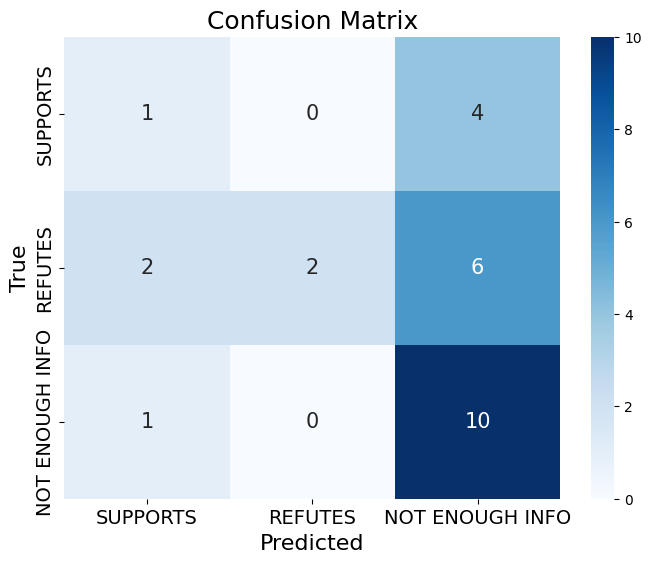

Accuracy: 0.5769
F1 Score (Micro): 0.5769
F1 Score (Macro): 0.5557
Confusion Matrix:
[[4 0 1]
 [4 3 3]
 [1 2 8]]


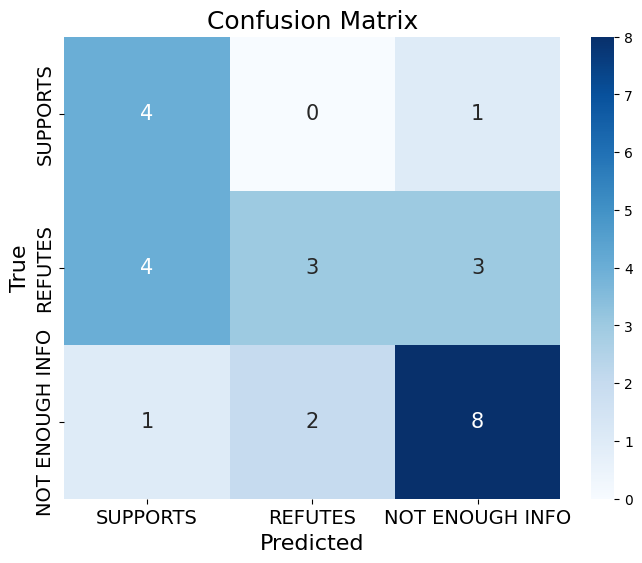

Accuracy: 0.5000
F1 Score (Micro): 0.5000
F1 Score (Macro): 0.4002
Confusion Matrix:
[[ 1  0  4]
 [ 2  2  6]
 [ 1  0 10]]


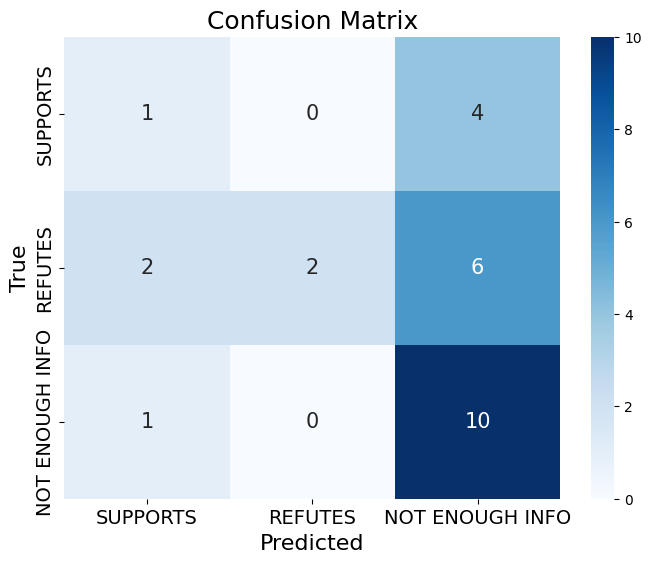

In [38]:
import torch
import numpy as np
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from preparing.data_loading import DataLoader
from preparing.data_cleaning import DataCleaner
from preparing.preprocessor import Preprocessor
from utils.preprocessing import preprocess_data
from utils.feature_extractor import FeatureExtractor
from utils.similarity_calculation import calculate_similarities
from evaluation.retrieval_evaluation import get_top_k_similar_timeline_entries
from evaluation.verification_evaluation import evaluate_llm_model
from utils.data_split import load_and_combine_datasets, stratified_split
from collections import Counter

# Load tokenizer and fine-tuned model
fine_tuned_model_path = '/Users/alaaeddinalia/Desktop/thesis_submission /Rumor_verification/src/traind_models/fine-tuned-xlm-roberta_EA'
tokenizer = XLMRobertaTokenizer.from_pretrained(fine_tuned_model_path)
model = XLMRobertaForSequenceClassification.from_pretrained(fine_tuned_model_path, num_labels=3)

train_file = '/Users/alaaeddinalia/Desktop/thesis_submission /Rumor_verification/data/raw/Arabic_train.json'
dev_file = '/Users/alaaeddinalia/Desktop/thesis_submission /Rumor_verification/data/raw/Arabic_dev.json'


#load data
data = load_and_combine_datasets(train_file, dev_file)

#clean data
cleaner = DataCleaner()
clean_data = cleaner.remove_invalid_tweets(data)

# Preprocess data
preprocessor = Preprocessor()
preprocessed_data = preprocess_data(data, preprocessor)

# Split the data into training and testing sets
train_data, test_data = stratified_split(preprocessed_data, label_key='label')

# Feature extractor (SBERT)
extractor = FeatureExtractor(method="sbert")

rumor_texts_test = [item['rumor'] for item in test_data]
timeline_texts_test = [timeline_entry[2] for item in test_data for timeline_entry in item['timeline']]

# Transform test data using SBERT
rumor_vectors_test = extractor.transform(rumor_texts_test)
timeline_vectors_test = extractor.transform(timeline_texts_test)

# Assign vectors back to rumors and timeline entries
rumor_index = 0
timeline_index = 0
for item in test_data:
    item['rumor_vector'] = rumor_vectors_test[rumor_index]
    rumor_index += 1
    for timeline_entry in item['timeline']:
        timeline_entry.append(timeline_vectors_test[timeline_index])
        timeline_index += 1

# Calculate similarities between rumors and timeline entries
similarities = calculate_similarities(test_data)


# Retrieve top k similar timeline entries for each rumor
top_k = 10 
for item in test_data:
    top_k_entries = get_top_k_similar_timeline_entries(similarities, item['id'], top_k)
    item['top_k_timeline'] = top_k_entries

# Prepare data for XLM-RoBERTa stance classification (rumor + top k evidence pairs)
rumor_evidence_pairs = []
for item in test_data:
    rumor = item['rumor']
    for timeline_entry in item['top_k_timeline']:
        evidence = timeline_entry['timeline_text']
        rumor_evidence_pairs.append(f"Rumor: {rumor} </s> Evidence: {evidence}")

# Tokenize the rumor + evidence pairs
test_encodings = tokenizer(rumor_evidence_pairs, truncation=True, padding=True, return_tensors='pt', max_length=256)

# Inference on the top k retrieved evidence for each rumor
model.eval()
with torch.no_grad():
    outputs = model(**test_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)  
    probabilities = torch.softmax(logits, dim=-1) 


prediction_idx = 0
for item in test_data:
    for timeline_entry in item['top_k_timeline']:
        timeline_entry['stance_prediction'] = predictions[prediction_idx].item()  
        timeline_entry['stance_probabilities'] = probabilities[prediction_idx].cpu().numpy()  
        prediction_idx += 1
        

def majority_voting(test_data):
    final_stances = []
    for item in test_data:
        stances = [timeline_entry['stance_prediction'] for timeline_entry in item['top_k_timeline']]
        most_common_stance = Counter(stances).most_common(1)[0][0]
        final_stances.append(most_common_stance)
    return final_stances


def weighted_voting(test_data, class_weights):
    final_stances = []
    
    for item in test_data:
        support_count = 0
        refute_count = 0
        noinfo_count = 0
        
        for timeline_entry in item['top_k_timeline']:
            if timeline_entry['stance_prediction'] == 0:  
                support_count += 1
            elif timeline_entry['stance_prediction'] == 1:  
                refute_count += 1
            elif timeline_entry['stance_prediction'] == 2:  
                noinfo_count += 1
        
        support_score = support_count * class_weights[0]
        refute_score = refute_count * class_weights[1]
        noinfo_score = noinfo_count * class_weights[2]
        
        stance_scores = [support_score, refute_score, noinfo_score]
        
        # Choose the label with the highest score
        final_stance = np.argmax(stance_scores)
        final_stances.append(final_stance)
    
    return final_stances


def soft_voting(test_data):
    final_stances = []
    
    for item in test_data:
        stance_scores = [0, 0, 0] 
        
        for timeline_entry in item['top_k_timeline']:
            stance_scores[0] += timeline_entry['stance_probabilities'][0]  
            stance_scores[1] += timeline_entry['stance_probabilities'][1]  
            stance_scores[2] += timeline_entry['stance_probabilities'][2] 
        
        
        final_stance = np.argmax(stance_scores)
        final_stances.append(final_stance)
    
    return final_stances

#  class weights(based on dataset distribution)
class_weights = [0.6, 0.38, 0.02]  

final_stances_majority = majority_voting(test_data)

final_stances_weighted = weighted_voting(test_data, class_weights)

final_stances_soft = soft_voting(test_data)

label_mapping = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT ENOUGH INFO": 2
}


true_labels = [label_mapping[item['label']] for item in test_data]



evaluate_llm_model(true_labels, final_stances_majority)

evaluate_llm_model(true_labels, final_stances_weighted)

evaluate_llm_model(true_labels, final_stances_soft)


In [39]:
# weighted voting
evidence = collect_evidence(test_data,final_stances_weighted)

recall = evaluate_recall_evidence(evidence)
map = evaluate_map_evidence(evidence) 

print(f"Recall@5: {recall :.4f} ")
print(f"MAP: {map :.4f}")

Recall@5: 0.6222 
MAP: 0.5778


In [52]:
# majority voting
evidence = collect_evidence(test_data,final_stances_majority)

recall = evaluate_recall_evidence(evidence)
map = evaluate_map_evidence(evidence) 

print(f"Recall@5: {recall :.4f} ")
print(f"MAP: {map :.4f}")

Recall@5: 0.3333 
MAP: 0.2889


In [42]:
# soft voting
evidence = collect_evidence(test_data,final_stances_soft)

recall = evaluate_recall_evidence(evidence)
map = evaluate_map_evidence(evidence) 

print(f"Recall@5: {recall :.4f} ")
print(f"MAP: {map :.4f}")

Recall@5: 0.3333 
MAP: 0.2889
